<a href="https://colab.research.google.com/github/Danafr00/stock_forecasting/blob/main/StockMarket_LSTM%2BSarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --quiet
!pip install pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
import yfinance as yf
from datetime import datetime
from datetime import timedelta
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import pickle
from sklearn.preprocessing import MinMaxScaler
import pickle
from tqdm.notebook import tnrange

from google.cloud import bigquery
from google.oauth2 import service_account

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM , Bidirectional

In [ ]:
data = yf.download("GOOGL" , start = "2018-01-01" , interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.shape

(1402, 6)

In [ ]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000


Understanding Trends with in the Data

In [ ]:
# Sort the data points based on indexes just for confirmation
data.sort_index(inplace = True)

In [ ]:
# Remove any duplicate index
data = data.loc[~data.index.duplicated(keep='first')]

In [ ]:
data.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-26,130.070007,130.979996,128.320007,129.270004,129.270004,61682100
2023-07-27,131.669998,133.240005,128.789993,129.399994,129.399994,44952100
2023-07-28,130.779999,133.740005,130.570007,132.580002,132.580002,36572900


In [ ]:
# Check for missing values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
# Get the statistics of the data
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1.402000e+03
mean,87.919671,88.934855,86.944685,87.961924,87.961924,3.542642e+07
std,30.172822,30.487841,29.829435,30.152258,30.152258,1.585350e+07
min,49.216000,50.605999,48.882999,49.233501,49.233501,9.312000e+06
25%,59.496251,60.011874,58.825000,59.508625,59.508625,2.542052e+07
50%,79.349003,80.557499,78.570499,79.278500,79.278500,3.158600e+07
75%,113.506752,115.364502,112.765749,114.003000,114.003000,4.027900e+07
max,151.250000,151.546494,148.899002,149.838501,149.838501,1.331780e+08


In [ ]:
import plotly.graph_objects as go

# Check the trend in Closing Values
fig = go.Figure()

fig.add_trace(go.Scatter(x = data.index , y = data['Close'] , mode = 'lines'))
fig.update_layout(height = 500 , width = 900,
                  xaxis_title='Date' , yaxis_title='Close')
fig.show()

In [ ]:
# Check the trend in Volume Traded
fig = go.Figure()

fig.add_trace(go.Scatter(x = data.index , y = data['Volume'] , mode = 'lines'))
fig.update_layout(height = 500 , width = 900,
                  xaxis_title='Date' , yaxis_title='Volume')
fig.show()

Data Preparation

In [ ]:
# Filter only required data
data = data[['Close']]
data.head(3)

,Close
Date,
2018-01-02,53.660500
2018-01-03,54.576000
2018-01-04,54.787998


In [ ]:
data.shape

(1402, 1)

In [ ]:
Feature_Scaler = MinMaxScaler()
data_transformed = pd.DataFrame(np.squeeze(Feature_Scaler.fit_transform(data), axis=1), columns=["Close"], index=data.index)

In [ ]:
def save_object(obj , name : str):
    pickle_out = open(f"{name}.pkl","wb")
    pickle.dump(obj, pickle_out)
    pickle_out.close()

def load_object(name : str):
    pickle_in = open(f"{name}.pkl","rb")
    data = pickle.load(pickle_in)
    return data

# Save your objects for future purposes
save_object(Feature_Scaler , "Scaler")

In [ ]:
data_transformed

,Close
Date,
2018-01-02,0.044004
2018-01-03,0.053104
2018-01-04,0.055211
2018-01-05,0.062432
2018-01-08,0.064380
...,...
2023-07-24,0.718617
2023-07-25,0.725376
2023-07-26,0.795552


## SARIMA MODEL

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
sarima_model = pm.auto_arima(data_transformed["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

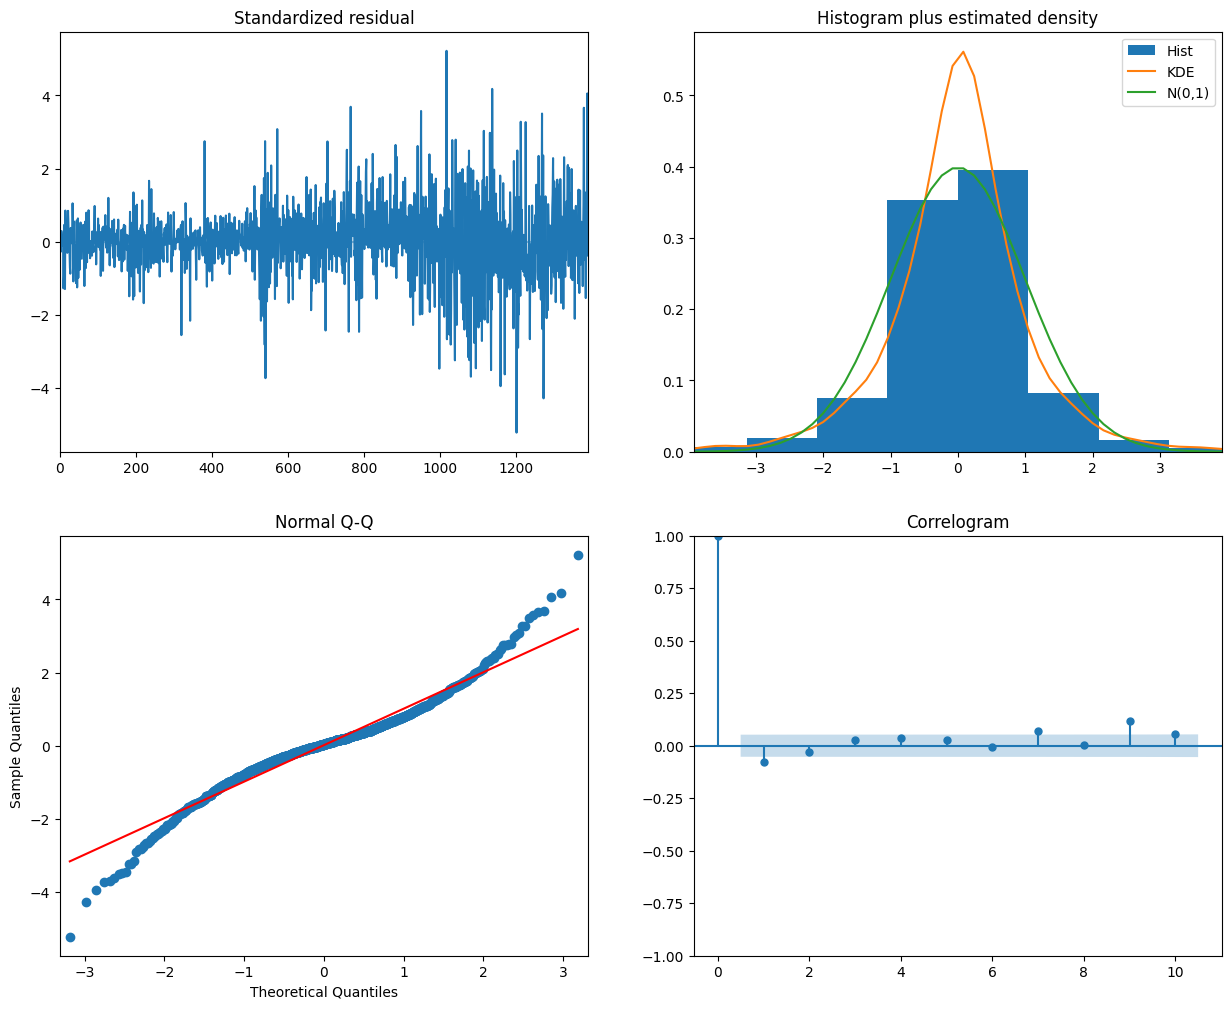

In [ ]:
sarima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
# Serialize with Pickle
with open('sarima_model.pkl', 'wb') as pkl:
    pickle.dump(sarima_model, pkl)

# Now read it back and make a prediction
with open('sarima_model.pkl', 'rb') as pkl:
    loaded_model = pickle.load(pkl)

In [ ]:
def forecast(model, df, forecast_date):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result


test=forecast(loaded_model, data_transformed, "2023-08-14")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
test

,Actual,Prediction,Low,High
2018-01-02,53.250000,NaN,NaN,NaN
2018-01-03,54.124001,NaN,NaN,NaN
2018-01-04,54.320000,NaN,NaN,NaN
2018-01-05,55.111500,NaN,NaN,NaN
2018-01-08,55.347000,NaN,NaN,NaN
...,...,...,...,...
2023-08-10,NaN,127.871416,115.307391,140.435441
2023-08-11,NaN,127.799994,114.838028,140.761960
2023-08-12,NaN,127.109693,113.781234,140.438152
2023-08-13,NaN,126.480369,112.826237,140.134501


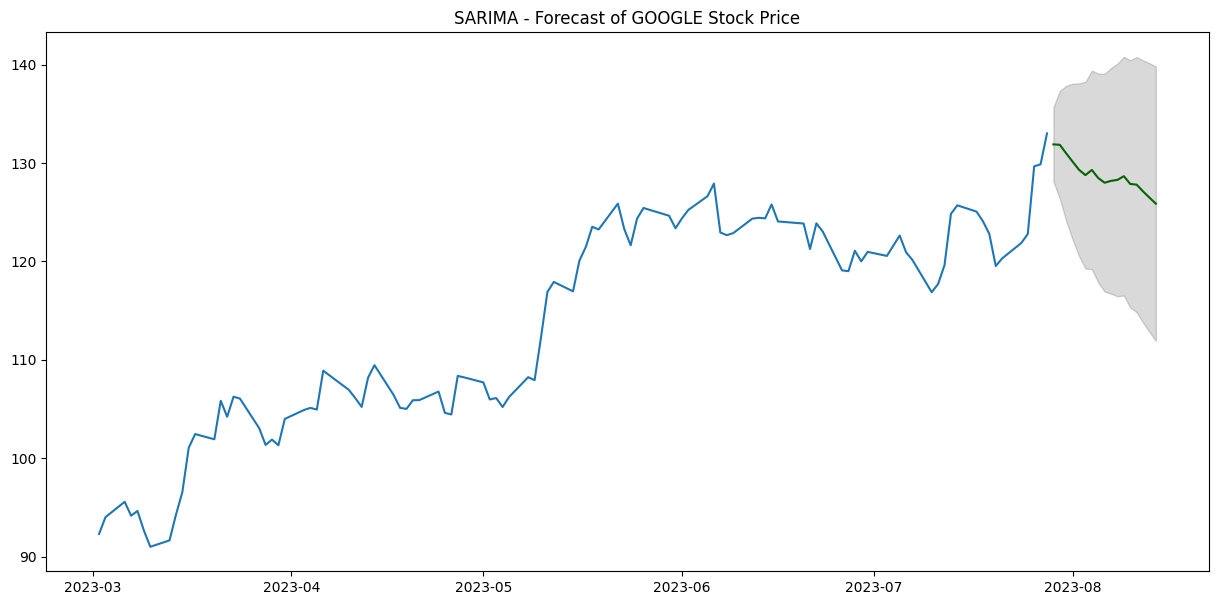

In [ ]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(test["Actual"][-120:], color='#1f76b4')
plt.plot(test["Prediction"], color='darkgreen')
plt.fill_between(test.index,
                test["Low"],
                test["High"],
                color='k', alpha=.15)

plt.title("SARIMA - Forecast of GOOGLE Stock Price")
plt.show()

## LSTM Model

In [ ]:
data_transformed

,Close
Date,
2018-01-02,0.044004
2018-01-03,0.053104
2018-01-04,0.055211
2018-01-05,0.062432
2018-01-08,0.064380
...,...
2023-07-24,0.718617
2023-07-25,0.725376
2023-07-26,0.795552


In [ ]:
def CreateFeatures_and_Targets(data, feature_length):
    X = []
    Y = []

    for i in tnrange(len(data) - feature_length):
        X.append(data[i : i + feature_length])
        Y.append(data[i+feature_length])

    X = np.array(X).reshape(len(X), feature_length, 1)
    Y = np.array(Y).reshape(len(Y), 1)

    return X , Y

In [ ]:
X , Y = CreateFeatures_and_Targets(data_transformed["Close"].values , 20)

  0%|          | 0/1382 [00:00<?, ?it/s]

In [ ]:
X

array([[[0.04400376],
        [0.05310371],
        [0.05521094],
        ...,
        [0.10083492],
        [0.1002982 ],
        [0.09577057]],

       [[0.05310371],
        [0.05521094],
        [0.06243227],
        ...,
        [0.1002982 ],
        [0.09577057],
        [0.09818099]],

       [[0.05521094],
        [0.06243227],
        [0.06438047],
        ...,
        [0.09577057],
        [0.09818099],
        [0.09786787]],

       ...,

       [[0.68680981],
        [0.70519854],
        [0.69446347],
        ...,
        [0.70360813],
        [0.71861734],
        [0.72537645]],

       [[0.70519854],
        [0.69446347],
        [0.70042737],
        ...,
        [0.71861734],
        [0.72537645],
        [0.79555194]],

       [[0.69446347],
        [0.70042737],
        [0.70241539],
        ...,
        [0.72537645],
        [0.79555194],
        [0.79684402]]])

In [ ]:
Y

array([[0.09818099],
       [0.09786787],
       [0.06686047],
       ...,
       [0.79555194],
       [0.79684402],
       [0.82845287]])

In [ ]:
# Confirm the Testing Set length
test_length = data[(data.index >= '2022-01-01')].shape[0]

In [ ]:
Xtrain , Xtest , Ytrain , Ytest = X[:-test_length] , X[-test_length:] , Y[:-test_length] , Y[-test_length:]

In [ ]:
# Check Training Dataset Shape
Xtrain.shape , Ytrain.shape

((988, 20, 1), (988, 1))

In [ ]:
# Check Testing Dataset Shape
Xtest.shape , Ytest.shape

((394, 20, 1), (394, 1))

Model Building

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau

save_best = ModelCheckpoint("best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=4, min_lr=0.00001,verbose = 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM , Bidirectional

model = Sequential()

model.add(Bidirectional(LSTM(512 ,return_sequences=True , recurrent_dropout=0.1, input_shape=(20, 1))))
model.add(LSTM(256 ,recurrent_dropout=0.1))
model.add(Dropout(0.2))
model.add(Dense(64 , activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(32 , activation='elu'))
model.add(Dense(1 , activation='linear'))

In [ ]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.002)
model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
history = model.fit(Xtrain, Ytrain,
            epochs=10,
            batch_size = 1,
            verbose=1,
            shuffle=False ,
            validation_data=(Xtest , Ytest),
            callbacks=[reduce_lr , save_best])

Epoch 1/10
988/988 [==============================] - 112s 103ms/step - loss: 0.0025 - rmse: 0.0501 - val_loss: 0.1023 - val_rmse: 0.3199 - lr: 0.0020
Epoch 2/10
988/988 [==============================] - 98s 100ms/step - loss: 0.0062 - rmse: 0.0786 - val_loss: 0.0650 - val_rmse: 0.2549 - lr: 0.0020
Epoch 3/10
988/988 [==============================] - 98s 99ms/step - loss: 0.0048 - rmse: 0.0690 - val_loss: 0.0521 - val_rmse: 0.2282 - lr: 0.0020
Epoch 4/10
988/988 [==============================] - 98s 99ms/step - loss: 0.0039 - rmse: 0.0624 - val_loss: 0.0264 - val_rmse: 0.1625 - lr: 0.0020
Epoch 5/10
988/988 [==============================] - 93s 95ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0305 - val_rmse: 0.1745 - lr: 0.0020
Epoch 6/10
988/988 [==============================] - 97s 98ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0115 - val_rmse: 0.1073 - lr: 0.0020
Epoch 7/10
988/988 [==============================] - 97s 98ms/step - loss: 0.0021 - rmse: 0.0459 - val

In [ ]:
# Checking the model Structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (1, 20, 1024)            2105344   
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (1, 256)                  1311744   
                                                                 
 dropout (Dropout)           (1, 256)                  0         
                                                                 
 dense (Dense)               (1, 64)                   16448     
                                                                 
 dropout_1 (Dropout)         (1, 64)                   0         
                                                                 
 dense_1 (Dense)             (1, 32)                   2080      
                                                        

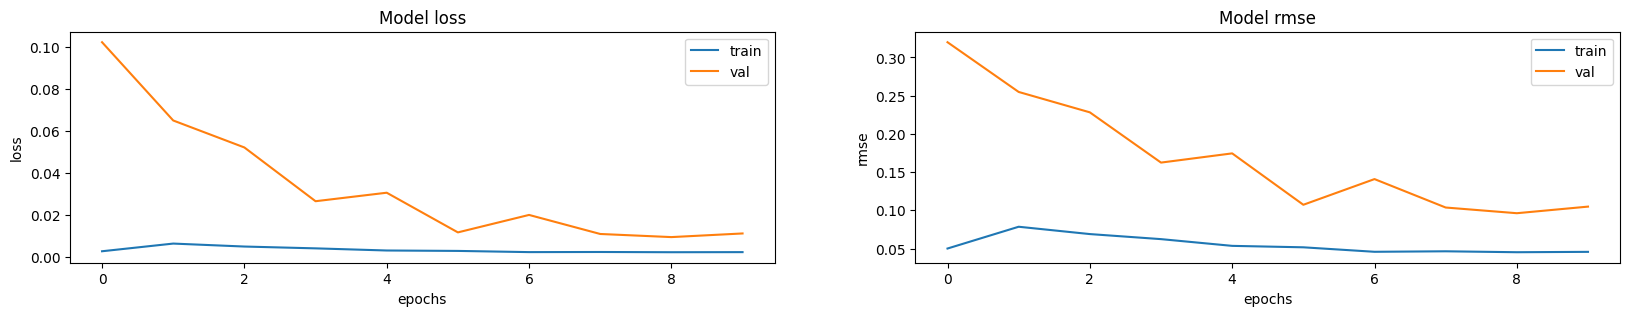

In [ ]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'rmse']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Load the best weights
model.load_weights("best_weights.h5")

Visualize prediction on Test Set

In [ ]:
Predictions = model.predict(Xtest)

13/13 [==============================] - 1s 21ms/step


In [ ]:
Predictions = Feature_Scaler.inverse_transform(Predictions)
Actual = Feature_Scaler.inverse_transform(Ytest)

In [ ]:
Predictions = np.squeeze(Predictions , axis = 1)
Actual = np.squeeze(Actual , axis = 1)

In [ ]:
# Creating Sample Test Dataframe
test_dataframe_dict = {'Actual' : list(Actual) , 'Predicted' : list(Predictions)}
test_df = pd.DataFrame.from_dict(test_dataframe_dict)

test_df.index = data.index[-test_length:]

In [ ]:
test_df.head()

,Actual,Predicted
Date,,
2022-01-03,144.991501,144.204483
2022-01-04,144.399506,144.190887
2022-01-05,137.774994,144.122437
2022-01-06,137.747498,143.582245
2022-01-07,137.016998,143.024750


In [ ]:
# Check the trend in Volume Traded
fig = go.Figure()

fig.add_trace(go.Scatter(x = test_df.index , y = Actual , mode = 'lines' , name='Actual'))
fig.add_trace(go.Scatter(x = test_df.index , y = Predictions , mode = 'lines' , name='Predicted'))
fig.show()

Visualize Prediction on whole data

In [ ]:
Total_features = np.concatenate((Xtrain , Xtest) , axis = 0)

In [ ]:
Total_Targets = np.concatenate((Ytrain , Ytest) , axis = 0)

In [ ]:
Predictions = model.predict(Total_features)

44/44 [==============================] - 1s 20ms/step


In [ ]:
Predictions = Feature_Scaler.inverse_transform(Predictions)
Actual = Feature_Scaler.inverse_transform(Total_Targets)

In [ ]:
Predictions = np.squeeze(Predictions , axis = 1)
Actual = np.squeeze(Actual , axis = 1)

In [ ]:
# Check the trend in Volume Traded
fig = go.Figure()

fig.add_trace(go.Scatter(x = data.index , y = Actual , mode = 'lines' , name='Actual'))
fig.add_trace(go.Scatter(x = data.index , y = Predictions , mode = 'lines' , name='Predicted'))
fig.show()

In [ ]:
model.predict(data_transformed[-21:-1].values.reshape(1,20,1))

1/1 [==============================] - 0s 45ms/step


array([[0.78141165]], dtype=float32)

In [ ]:
Total_features.shape

(1382, 20, 1)

In [ ]:
Predictions.shape

(1382,)

In [ ]:
data

,Close
Date,
2018-01-02,53.660500
2018-01-03,54.576000
2018-01-04,54.787998
2018-01-05,55.514500
2018-01-08,55.710499
...,...
2023-07-24,121.529999
2023-07-25,122.209999
2023-07-26,129.270004


In [ ]:
def PredictStockPrice(Model , df , ForecastDate , feature_length = 20):
    for i in range((datetime.strptime(ForecastDate, '%Y-%m-%d') - df.index[-1]).days):
      Features = df.iloc[-20:].values.reshape(-1, 1)
      Features = Feature_Scaler.transform(Features)
      Prediction = Model.predict(Features.reshape(1,20,1))
      Prediction = Feature_Scaler.inverse_transform(Prediction)
      df_forecast = pd.DataFrame(Prediction, index=[df.index[-1]+ timedelta(days=1)], columns=['Close'])
      df = pd.concat([df, df_forecast])
    return df

In [ ]:
data = pd.DataFrame(data)
test = PredictStockPrice(model, data, '2023-08-01')

1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [ ]:
test.tail(10)

,Close
2023-07-21,120.019997
2023-07-24,121.529999
2023-07-25,122.209999
2023-07-26,129.270004
2023-07-27,129.399994
2023-07-28,132.580002
2023-07-29,128.645599
2023-07-30,129.140839
2023-07-31,129.613022
2023-08-01,130.056686


In [ ]:
test.loc[:str(date.today() + timedelta(days=1))]

,Close
2018-01-02,53.660500
2018-01-03,54.576000
2018-01-04,54.787998
2018-01-05,55.514500
2018-01-08,55.710499
...,...
2023-07-27,129.399994
2023-07-28,132.580002
2023-07-29,128.645599
2023-07-30,129.140839


In [ ]:
# Check the trend in Volume Traded
fig = go.Figure()

fig.add_trace(go.Scatter(x = test.tail(150).loc[:str(date.today() + timedelta(days=1))].index , y = test.tail(150).loc[:str(date.today() + timedelta(days=1))]["Close"], mode = 'lines' , name='Predicted'))
fig.add_trace(go.Scatter(x = test.loc[str(date.today() + timedelta(days=1)):].index , y = test.loc[str(date.today() + timedelta(days=1)):]["Close"], mode = 'lines' , name='Actual'))
fig.show()

## Combining 2 Models

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data = yf.download("GOOGL" , start = "2018-01-01" , interval = '1d')
# data.head()


credentials = service_account.Credentials.from_service_account_file(r"/content/drive/MyDrive/Portfolio/Stock Market Prediction/latihan-345909-89e4eb39e2b1.json")
project_id = 'latihan-345909'
table_id = 'latihan-345909.stocks.stocks_table'
client = bigquery.Client(credentials=credentials, project=project_id)

sql = """
WITH latest_date AS (
  SELECT MAX(jakarta_data_date) as max_date
FROM `latihan-345909.stocks.stocks_table`
)

SELECT *
FROM latihan-345909.stocks.stocks_table
WHERE jakarta_data_date = (SELECT max_date FROM latest_date)
"""

bq_df = client.query(sql).to_dataframe()

data = bq_df.copy()
data.head()

,date,open,high,low,close,adj_close,volume,stochrsi,macd,macds,macdh,mfi,company_name,jakarta_data_date
0,2018-01-02,52.417000,53.347000,52.261501,53.250000,53.250000,24752000,NaN,0.000000,0.000000,0.000000,0.5,GOOG,2023-07-31
1,2018-01-03,53.215500,54.314499,53.160500,54.124001,54.124001,28604000,NaN,0.019609,0.010894,0.008715,0.5,GOOG,2023-07-31
2,2018-01-04,54.400002,54.678501,54.200100,54.320000,54.320000,20092000,NaN,0.031064,0.019160,0.011903,0.5,GOOG,2023-07-31
3,2018-01-05,54.700001,55.212502,54.599998,55.111500,55.111500,25582000,NaN,0.064089,0.034380,0.029709,0.5,GOOG,2023-07-31
4,2018-01-08,55.111500,55.563499,55.081001,55.347000,55.347000,20952000,NaN,0.090056,0.050942,0.039114,0.5,GOOG,2023-07-31


In [6]:
data.set_index('date', inplace=True)

In [7]:
data.columns

Index(['open', 'high', 'low', 'close', 'adj_close', 'volume', 'stochrsi',
       'macd', 'macds', 'macdh', 'mfi', 'company_name', 'jakarta_data_date'],
      dtype='object')

In [8]:
data = data[['high', 'low', 'close', 'adj_close', 'volume', 'stochrsi',
       'macd', 'macds', 'macdh', 'mfi', 'company_name', 'jakarta_data_date', 'open']]
data

,high,low,close,adj_close,volume,stochrsi,macd,macds,macdh,mfi,company_name,jakarta_data_date,open
date,,,,,,,,,,,,,
2018-01-02,53.347000,52.261501,53.250000,53.250000,24752000,NaN,0.000000,0.000000,0.000000,0.500000,GOOG,2023-07-31,52.417000
2018-01-03,54.314499,53.160500,54.124001,54.124001,28604000,NaN,0.019609,0.010894,0.008715,0.500000,GOOG,2023-07-31,53.215500
2018-01-04,54.678501,54.200100,54.320000,54.320000,20092000,NaN,0.031064,0.019160,0.011903,0.500000,GOOG,2023-07-31,54.400002
2018-01-05,55.212502,54.599998,55.111500,55.111500,25582000,NaN,0.064089,0.034380,0.029709,0.500000,GOOG,2023-07-31,54.700001
2018-01-08,55.563499,55.081001,55.347000,55.347000,20952000,NaN,0.090056,0.050942,0.039114,0.500000,GOOG,2023-07-31,55.111500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-13,125.334999,121.059998,124.830002,124.830002,31535900,100.0,-0.109444,0.029191,-0.138635,0.585384,GOOG,2023-07-31,121.540001
2023-07-14,127.089996,124.900002,125.699997,125.699997,20482800,100.0,0.286751,0.080703,0.206048,0.573688,GOOG,2023-07-31,125.129997
2023-07-26,131.369995,128.710007,129.660004,129.660004,46216900,100.0,0.853188,0.397544,0.455643,0.501803,GOOG,2023-07-31,130.360001


In [9]:
data.head()


,high,low,close,adj_close,volume,stochrsi,macd,macds,macdh,mfi,company_name,jakarta_data_date,open
date,,,,,,,,,,,,,
2018-01-02,53.347000,52.261501,53.250000,53.250000,24752000,NaN,0.000000,0.000000,0.000000,0.5,GOOG,2023-07-31,52.417000
2018-01-03,54.314499,53.160500,54.124001,54.124001,28604000,NaN,0.019609,0.010894,0.008715,0.5,GOOG,2023-07-31,53.215500
2018-01-04,54.678501,54.200100,54.320000,54.320000,20092000,NaN,0.031064,0.019160,0.011903,0.5,GOOG,2023-07-31,54.400002
2018-01-05,55.212502,54.599998,55.111500,55.111500,25582000,NaN,0.064089,0.034380,0.029709,0.5,GOOG,2023-07-31,54.700001
2018-01-08,55.563499,55.081001,55.347000,55.347000,20952000,NaN,0.090056,0.050942,0.039114,0.5,GOOG,2023-07-31,55.111500


In [10]:
# Now read it back and make a prediction
def load_object(name : str):
    pickle_in = open(f"{name}","rb")
    data = pickle.load(pickle_in)
    return data

def data_transformation(df, scaler):
  try:
    data = pd.DataFrame(np.squeeze(scaler.transform(df), axis=1), columns=df.columns, index=df.index)
  except:
    data = pd.DataFrame(np.squeeze(scaler.transform(df.values.reshape(-1, 1)), axis=1), columns=[df.name], index=df.index)
  return data

In [11]:
scaler = load_object("/content/drive/MyDrive/Portfolio/Stock Market Prediction/scaler.pkl")

data_transformed = data_transformation(data["close"], scaler)
data_transformed.tail()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,close
date,
2023-07-13,0.751419
2023-07-14,0.760067
2023-07-26,0.799428
2023-07-27,0.801516
2023-07-28,0.832727


In [12]:
last_date_timestamp = data_transformed.index[-1]
last_date_timestamp

Timestamp('2023-07-28 00:00:00')

In [13]:
sarima_model = load_object("/content/drive/MyDrive/Portfolio/Stock Market Prediction/sarima_model.pkl")

In [14]:
# (data_transformed.index[-1]+ timedelta(days=i+1)).strftime("%Y-%m-%d")

In [15]:
pd.date_range(data_transformed.index[-1] + pd.DateOffset(days=1), periods = 4, freq='D')

DatetimeIndex(['2023-07-29', '2023-07-30', '2023-07-31', '2023-08-01'], dtype='datetime64[ns]', freq='D')

In [16]:
def forecast(model, df, forecast_date, scaler):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    for column in df_result.columns:
      df_result[column] = scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

In [17]:
test=forecast(sarima_model, data_transformed, "2023-08-14", scaler)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [18]:
test.tail(15)

,Actual,Prediction,Low,High
2023-07-31,NaN,130.976557,124.109937,137.843178
2023-08-01,NaN,130.134603,122.212060,138.057145
2023-08-02,NaN,129.311718,120.536247,138.087188
2023-08-03,NaN,128.769941,119.283216,138.256667
2023-08-04,NaN,129.293541,119.201752,139.385329
2023-08-05,NaN,128.474442,117.860860,139.088024
2023-08-06,NaN,127.994688,116.926650,139.062725
2023-08-07,NaN,128.185570,116.718756,139.652384
2023-08-08,NaN,128.282224,116.463445,140.101002
2023-08-09,NaN,128.661114,116.530239,140.791989


In [19]:
def create_model():
  model = Sequential()

  model.add(Bidirectional(LSTM(512 ,return_sequences=True , recurrent_dropout=0.1, input_shape=(20, 1))))
  model.add(LSTM(256 ,recurrent_dropout=0.1))
  model.add(Dropout(0.2))
  model.add(Dense(64 , activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(32 , activation='elu'))
  model.add(Dense(1 , activation='linear'))

  optimizer = tf.keras.optimizers.SGD(learning_rate = 0.002)
  model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

  return model

In [20]:
test_data = data_transformed.iloc[-21:-1].values.reshape(1,20,1)
target_data = data_transformed.iloc[-1].values.reshape(1,1)

lstm_model = create_model()

lstm_model.evaluate(test_data, target_data)

lstm_model.load_weights("/content/drive/MyDrive/Portfolio/Stock Market Prediction/best_weights_lstm.h5")

lstm_model.summary()

1/1 [==============================] - 6s 6s/step - loss: 0.7908 - rmse: 0.8893
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 1024)         2105344   
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 256)               1311744   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)   

In [21]:
def PredictStockPrice(Model , df , ForecastDate , scaler, feature_length = 20):
    for i in range((datetime.strptime(ForecastDate, '%Y-%m-%d') - df.index[-1]).days):
      Features = df.iloc[-20:].values.reshape(-1, 1)
      Prediction = Model.predict(Features.reshape(1,20,1))
      df_forecast = pd.DataFrame(Prediction, index=[df.index[-1]+ timedelta(days=1)], columns=['close'])
      df = pd.concat([df, df_forecast])
    df = pd.DataFrame(np.squeeze(scaler.inverse_transform(df)),
                      index=df.index, columns=['close'])
    return df

In [22]:
test = PredictStockPrice(lstm_model, data_transformed, "2023-08-14", scaler)

1/1 [==============================] - 0s 33ms/step


In [23]:
test.tail(20)

,close
2023-07-26,129.660004
2023-07-27,129.869995
2023-07-28,133.009995
2023-07-29,126.786695
2023-07-30,127.607739
2023-07-31,128.338295
2023-08-01,128.967247
2023-08-02,129.633521
2023-08-03,130.252003
2023-08-04,130.809188


In [24]:
def combine_model(data_transformed, lstm_model, sarima_model, forecast_date, scaler):
  df_low = pd.DataFrame(columns=['Low'])
  df_high = pd.DataFrame(columns=["High"])
  last_initial_date = data_transformed.index[-1]

  for i in range((datetime.strptime(forecast_date, '%Y-%m-%d') - data_transformed.index[-1]).days):
    df_lstm_temp = PredictStockPrice(lstm_model, data_transformed, (data_transformed.index[-1]+ timedelta(days=1)).strftime("%Y-%m-%d"), scaler)
    df_sarima_temp = forecast(sarima_model, data_transformed, (data_transformed.index[-1]+ timedelta(days=i+1)).strftime("%Y-%m-%d"), scaler)

    prediction = scaler.transform(df_lstm_temp.iloc[-1]["close"].reshape(1,-1)) * 0.3 + scaler.transform(df_sarima_temp.iloc[-1]["Prediction"].reshape(1,-1)) *0.7

    df_forecast = pd.DataFrame(prediction,
                              index=[data_transformed.index[-1]+ timedelta(days=1)], columns=['close'])


    data_transformed = pd.concat([data_transformed, df_forecast])

    df_low = pd.concat([df_low, pd.DataFrame(df_sarima_temp.iloc[-1]["Low"],
                                          index=[data_transformed.index[-1]+ timedelta(days=1)],
                                          columns=["Low"])
    ])
    df_high = pd.concat([df_high, pd.DataFrame(df_sarima_temp.iloc[-1]["High"],
                                          index=[data_transformed.index[-1]+ timedelta(days=1)],
                                          columns=["High"])
    ])


  df_final = pd.DataFrame(np.squeeze(scaler.inverse_transform(data_transformed)),
                        index=data_transformed.index, columns=['close'])
  df_final_actual = df_final[:last_initial_date+ timedelta(days=1)]
  df_final_prediction = df_final[last_initial_date+ timedelta(days=1):]

  return df_final_actual, df_final_prediction, df_low,  df_high


In [25]:
df_final_actual, df_final_prediction, df_low, df_high = combine_model(data_transformed, lstm_model, sarima_model, "2023-08-14", scaler)

1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/lo

1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/lo

1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/lo

1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_m

1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/lo

1/1 [==============================] - 0s 42ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/lo

In [26]:
df_final_prediction


,close
2023-07-29,130.358982
2023-07-30,130.650955
2023-07-31,130.324412
2023-08-01,129.964986
2023-08-02,129.605155
2023-08-03,129.401777
2023-08-04,129.904834
2023-08-05,129.453783
2023-08-06,129.206950
2023-08-07,129.398069


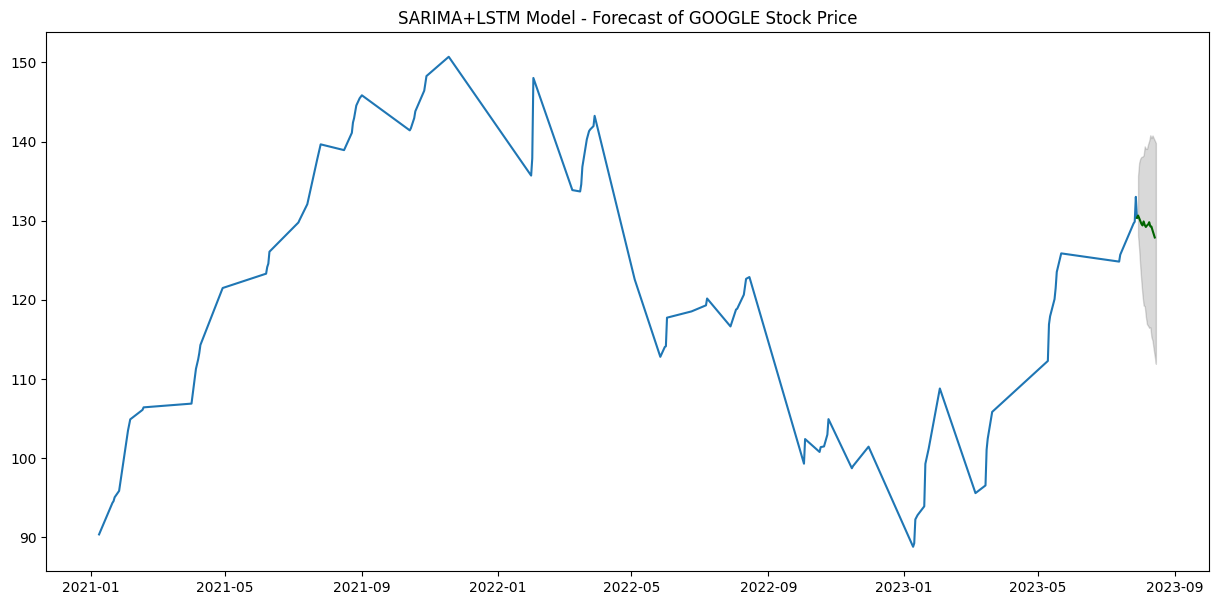

In [27]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(df_final_actual.tail(100), color='#1f76b4')
plt.plot(df_final_prediction, color='darkgreen')
plt.fill_between(df_low.index,
                df_low["Low"],
                df_high["High"],
                color='k', alpha=.15)

plt.title("SARIMA+LSTM Model - Forecast of GOOGLE Stock Price")
plt.show()

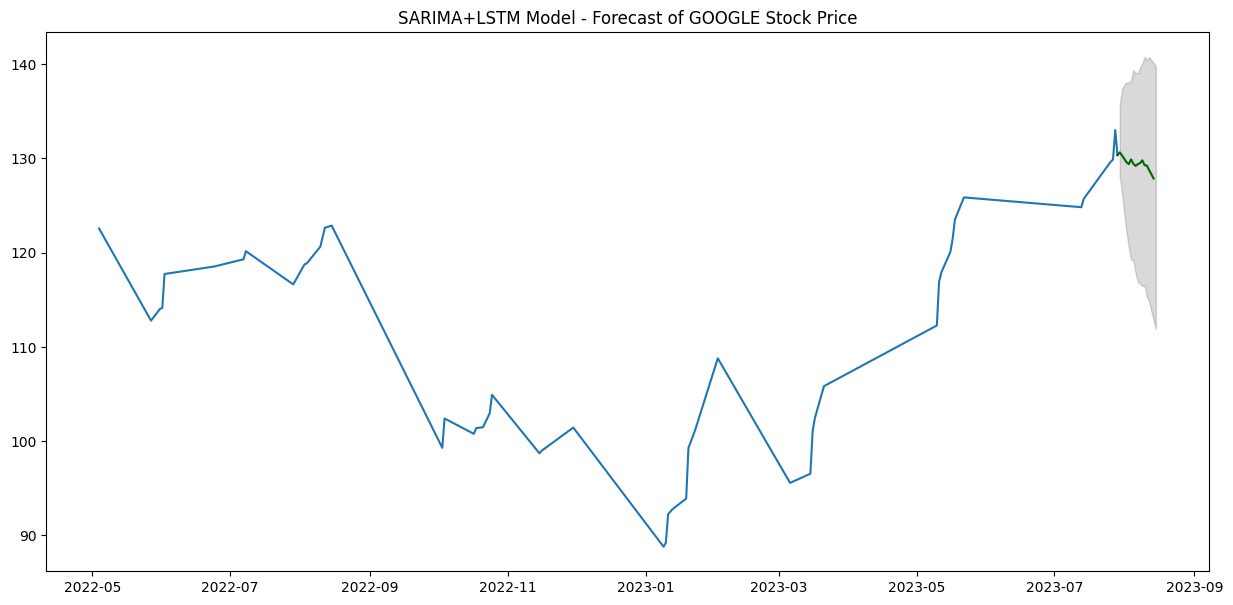

In [28]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(df_final_actual.tail(50), color='#1f76b4')
plt.plot(df_final_prediction, color='darkgreen')
plt.fill_between(df_low.index,
                df_low["Low"],
                df_high["High"],
                color='k', alpha=.15)

plt.title("SARIMA+LSTM Model - Forecast of GOOGLE Stock Price")
plt.show()